In [79]:
#import library
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import random
import holidays

from sklearn.metrics import mean_absolute_error,mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

In [80]:
#import data
df=pd.read_csv(r"C:\Users\q\Desktop\Case\ds_exercise_data.csv",sep=",")

In [81]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 3 columns):
Date       1186 non-null datetime64[ns]
CashIn     1081 non-null float64
CashOut    1098 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 27.9 KB


In [82]:
df_cash_out = df.rename(columns={'Date': 'ds', 'CashOut': 'y'})
df_cash_out = df_cash_out[["ds","y"]]
df_cash_out.head()

,ds,y
0,2016-01-01,6500.0
1,2016-01-02,23110.0
2,2016-01-03,7070.0
3,2016-01-04,18520.0
4,2016-01-05,22200.0


In [83]:
model3 = Prophet()

In [84]:
df_cash_out[:1096].head()

,ds,y
0,2016-01-01,6500.0
1,2016-01-02,23110.0
2,2016-01-03,7070.0
3,2016-01-04,18520.0
4,2016-01-05,22200.0


In [85]:
model3.fit(df_cash_out[:1096])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\q\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [86]:
df_last_3_month_cash_out=df[1096:]["CashOut"]
df_last_3_month_cash_out

1096    19440.0
1097    35700.0
1098    33900.0
1099    34970.0
1100    47050.0
         ...   
1181    48600.0
1182    22840.0
1183    25950.0
1184    24350.0
1185    14400.0
Name: CashOut, Length: 90, dtype: float64

In [87]:
forecast = model3.predict(df_cash_out[1096:])

          ds          yhat    yhat_lower    yhat_upper
0 2019-01-01  41028.067278  18592.899314  62159.866451
1 2019-01-02  39252.994696  18899.398545  60137.575671
2 2019-01-03  39103.073526  18020.737141  60277.638871
3 2019-01-04  42967.469687  22025.806089  63231.263447
4 2019-01-05  43945.256109  22295.711236  65732.706334


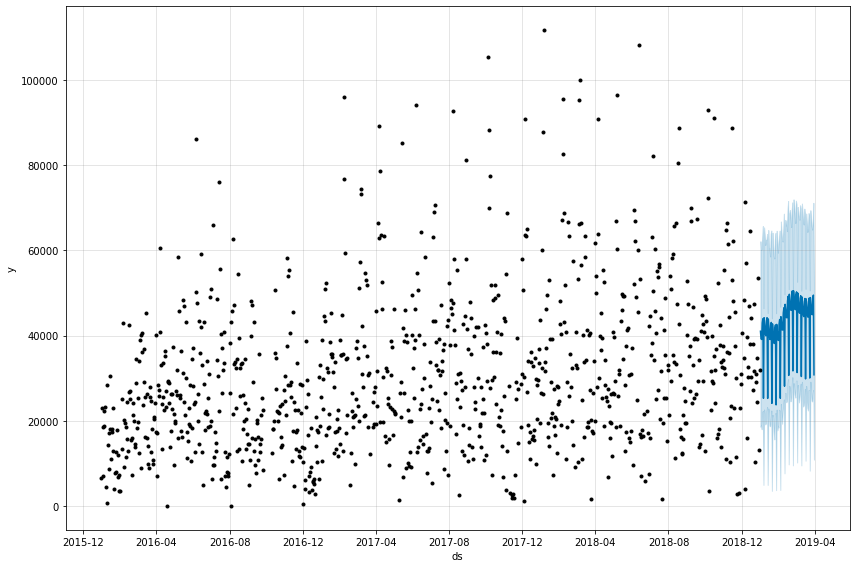

In [88]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model3.plot(forecast,figsize=(12,8))
plt.show()

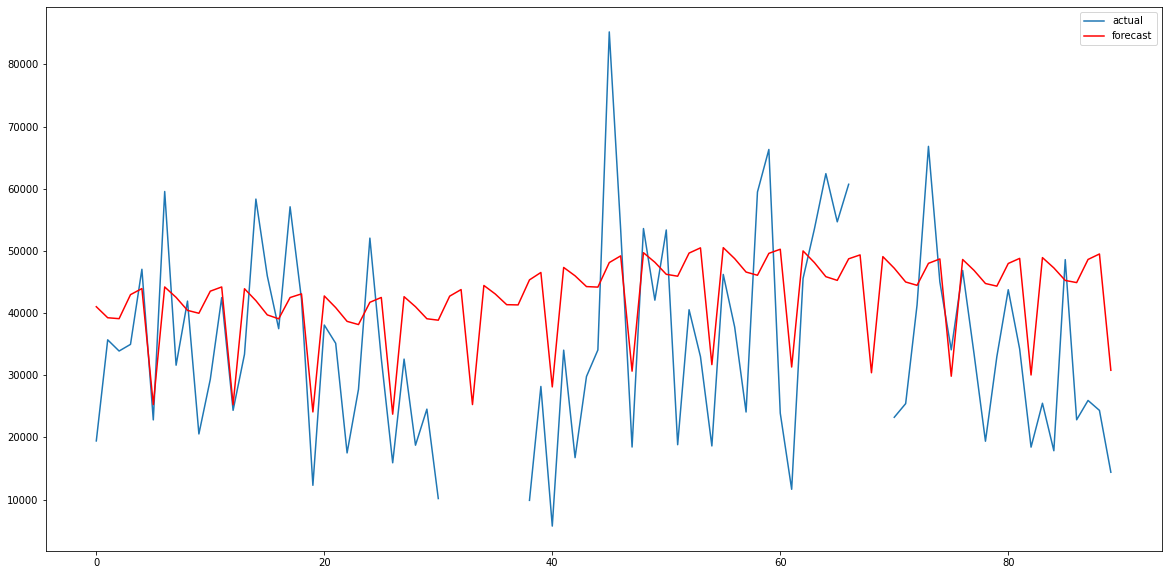

In [91]:
plt.figure(figsize=(20,10))
plt.plot(df_last_3_month_cash_out.reset_index()["CashOut"],label="actual")
plt.plot(forecast["yhat"],'r',label="forecast")
plt.legend()

In [92]:
df_cash_in[:1096].dropna(inplace=True)

NameError: name 'df_cash_in' is not defined

In [93]:
y_true=df_last_3_month_cash_out.reset_index()[df_last_3_month_cash_out.reset_index()["CashOut"].notna()]["CashOut"].tolist()

In [94]:
rows_with_nan = []
for index, row in df_cash_out[1096:].reset_index().iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

In [95]:
print(rows_with_nan)

[31, 32, 33, 34, 35, 36, 37, 67, 69]


In [96]:
y_pred = forecast.drop(index=[31, 32, 33, 34, 35, 36, 37, 67, 69])["yhat"].tolist()

In [97]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [98]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE",mape)

MAPE 58.9014464284038


### Grid Search for cash out
Prophet Model Tuning

In [29]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 30


In [30]:
strt='2019-01-01'
end='2019-03-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    model4 =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    model4.fit(df_cash_out[:1096])
    forecast = model4.predict(df_cash_out[1096:])
    forecast.head()
    y_true=df_last_3_month_cash_out.reset_index()[df_last_3_month_cash_out.reset_index()["CashOut"].notna()]["CashOut"].tolist()
    y_pred = forecast.drop(index=[31, 32, 33, 34, 35, 36, 37, 67, 69])["yhat"].tolist()
    
    MAPE = mean_absolute_percentage_error(y_true,y_pred)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 58.11491188311055
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.42495187181783
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 58.188556687134984
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.39392098857267
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.907227115253676
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive

In [31]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,57.351158,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
1,57.393921,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
2,57.424952,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
3,57.434240,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
4,57.562429,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."


Out of total 30 models, we will select the parameters which has the least MAPE to train the final model and predict the next months amount of the money for cash out.

Best Parameters on which the model has the least MAPE is:

In [32]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'n_changepoints': 200,
 'seasonality_mode': 'additive'}

In [38]:
# Setup and final model with best parameters
final_model = Prophet(changepoint_prior_scale= 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.fit(df_cash_out)

In [39]:
future = final_model.make_future_dataframe(periods=30, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1209,2019-04-24,39063.042648,7006.296521,68792.318341
1210,2019-04-25,38052.536953,6971.693087,67074.545378
1211,2019-04-26,42102.252634,10517.954378,72802.533601
1212,2019-04-27,41579.990720,9951.276866,72370.959416
1213,2019-04-28,22391.349729,-10941.550947,55235.357690
1214,2019-04-29,41217.236448,10364.390972,74051.311493
1215,2019-04-30,38532.416511,7753.299515,68936.176843


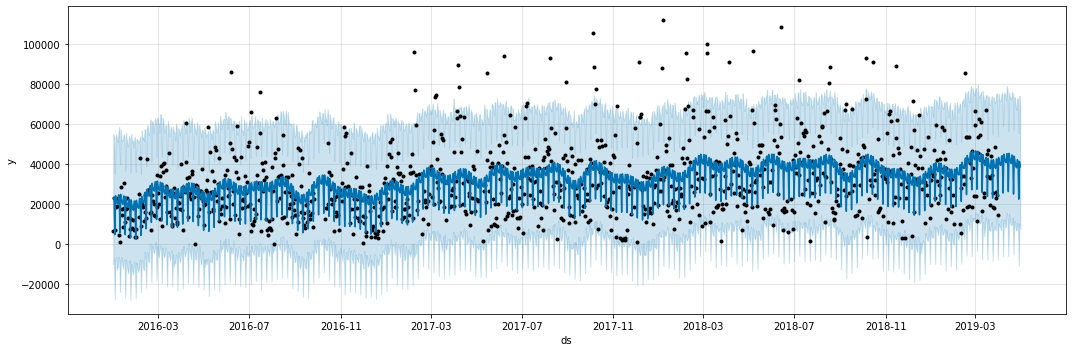

In [40]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [64]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,9337.894143,-10117.185683,54676.153923,9337.894143,9337.894143,13621.473350,13621.473350,13621.473350,11371.521204,...,4178.490470,4178.490470,4178.490470,-1928.538324,-1928.538324,-1928.538324,0.0,0.0,0.0,22959.367493
1,2016-01-02,9357.299341,-7728.031362,53502.651409,9357.299341,9357.299341,13793.128867,13793.128867,13793.128867,11371.521204,...,4034.098374,4034.098374,4034.098374,-1612.490711,-1612.490711,-1612.490711,0.0,0.0,0.0,23150.428208
2,2016-01-03,9376.704539,-27664.111418,35450.517613,9376.704539,9376.704539,-4742.951865,-4742.951865,-4742.951865,11371.521204,...,-14785.079265,-14785.079265,-14785.079265,-1329.393804,-1329.393804,-1329.393804,0.0,0.0,0.0,4633.752674
3,2016-01-04,9396.109737,-6875.843260,53437.913859,9396.109737,9396.109737,14683.675331,14683.675331,14683.675331,11371.521204,...,4395.002365,4395.002365,4395.002365,-1082.848237,-1082.848237,-1082.848237,0.0,0.0,0.0,24079.785068
4,2016-01-05,9415.514935,-6561.023054,55035.831552,9415.514935,9415.514935,12538.069974,12538.069974,12538.069974,11371.521204,...,2042.395348,2042.395348,2042.395348,-875.846578,-875.846578,-875.846578,0.0,0.0,0.0,21953.584909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,2019-04-26,26005.295513,10517.954378,72802.533601,25999.035725,26011.657769,16096.957120,16096.957120,16096.957120,11371.521204,...,4178.490470,4178.490470,4178.490470,546.945446,546.945446,546.945446,0.0,0.0,0.0,42102.252634
1212,2019-04-27,26010.066258,9951.276866,72370.959416,26003.365470,26016.750042,15569.924461,15569.924461,15569.924461,11371.521204,...,4034.098374,4034.098374,4034.098374,164.304883,164.304883,164.304883,0.0,0.0,0.0,41579.990720
1213,2019-04-28,26014.837003,-10941.550947,55235.357690,26007.747487,26021.842241,-3623.487275,-3623.487275,-3623.487275,11371.521204,...,-14785.079265,-14785.079265,-14785.079265,-209.929214,-209.929214,-209.929214,0.0,0.0,0.0,22391.349729
1214,2019-04-29,26019.607748,10364.390972,74051.311493,26012.230467,26027.007885,15197.628700,15197.628700,15197.628700,11371.521204,...,4395.002365,4395.002365,4395.002365,-568.894868,-568.894868,-568.894868,0.0,0.0,0.0,41217.236448
